In [1]:
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers

# 1. Pre-processing and compressing the dataset

In [3]:
# Set the same random seed, for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize and expand dimensions
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Load the trained encoder from the final autoencoder model
def create_autoencoder(latent_dim=(4, 4, 32), input_shape=(28, 28, 1)):
    class Autoencoder(tf.keras.models.Model):
        def __init__(self, latent_dim, shape):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dim
            self.shape = shape
            # Encoder
            self.encoder = tf.keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D((2, 2), padding='same'),
                layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D((2, 2), padding='same'),
                layers.Conv2D(latent_dim[2], (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D((2, 2), padding='same')
            ])
            # Decoder
            self.decoder = tf.keras.Sequential([
                layers.Conv2D(latent_dim[2], (3, 3), activation='relu', padding='same'),
                layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(1, (3, 3), strides=2, activation='sigmoid', padding='same'),
                layers.Cropping2D(((2, 2), (2, 2)))
            ])
        
        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    autoencoder = Autoencoder(latent_dim=latent_dim, shape=input_shape)
    # Initialize the model by passing a dummy input
    autoencoder(tf.zeros((1, *input_shape)))
    autoencoder.summary()
    return autoencoder

# Create the encoder model
latent_dim = (4, 4, 32) 
encoder = create_autoencoder(latent_dim)

# Load the saved weights
encoder.load_weights('model/optimal_autoencoder.weights.h5')

# Encode the entire training dataset
encoded_train = encoder.predict(x_train)
encoded_train_flat = encoded_train.reshape(encoded_train.shape[0], -1)

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (1, 4, 4, 32)          │        37,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (1, 28, 28, 1)         │        46,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


# 2. Find the nearest neighbors

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


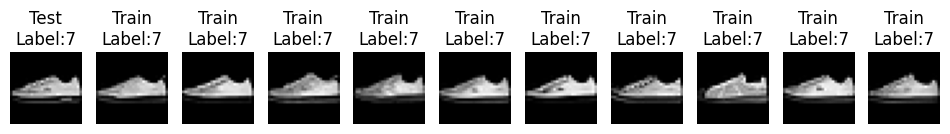

In [7]:
# Select and encode a random sample from the test dataset
import random
random_idx = random.randint(0, x_test.shape[0] - 1)
test_sample = x_test[random_idx]
test_label = y_test[random_idx]

encoded_test_sample = encoder.predict(np.expand_dims(test_sample, axis=0))
encoded_test_sample_flat = encoded_test_sample.reshape(1, -1)

# Build k-nearest neighbors model
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(encoded_train_flat)

# Find the 10 closest training samples
distances, indices = knn.kneighbors(encoded_test_sample_flat)
closest_images = x_train[indices[0]]
closest_labels = y_train[indices[0]]

# Plot the test sample and the 10 closest training samples with their labels
plt.figure(figsize=(12, 2))
plt.subplot(1, 11, 1)
plt.imshow(test_sample.squeeze(), cmap='gray')
plt.title(f'Test\nLabel:{test_label}')
plt.axis('off')

for i in range(10):
    plt.subplot(1, 11, i + 2)
    plt.imshow(closest_images[i].squeeze(), cmap='gray')
    plt.title(f'Train\nLabel:{closest_labels[i]}')
    plt.axis('off')

plt.show()

We can indeed see that the nearest neighbors are visually similar to the test sample. This is expected since the autoencoder has compressed the images into a lower-dimensional space where similar images are close together. 

# 3. Diagnose the classifier

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


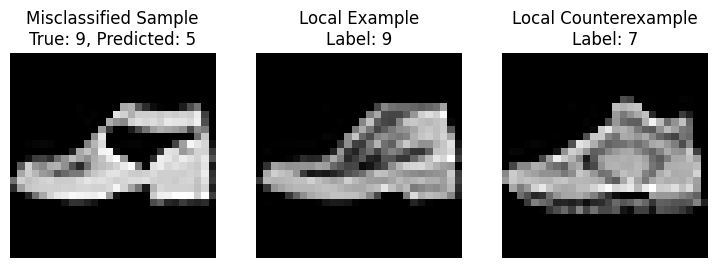

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


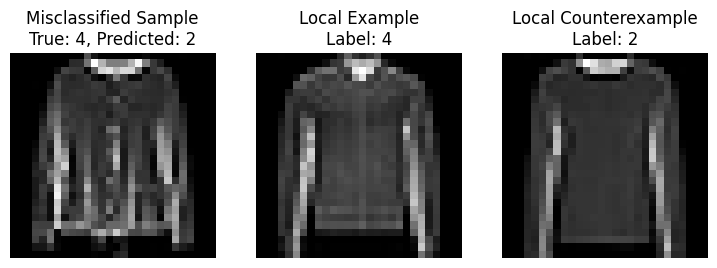

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


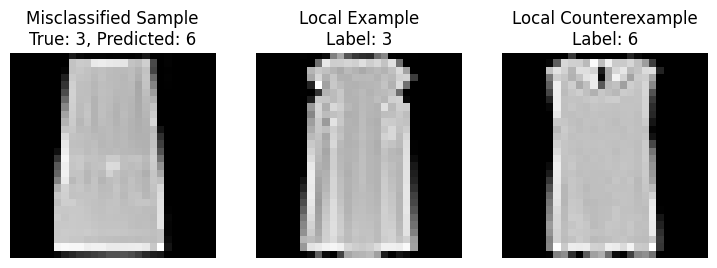

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


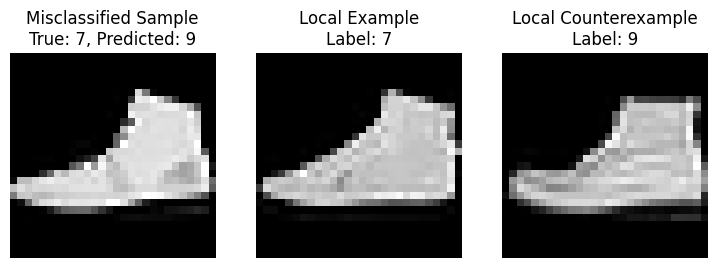

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


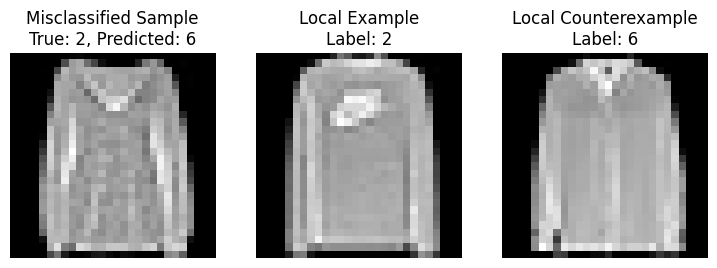

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


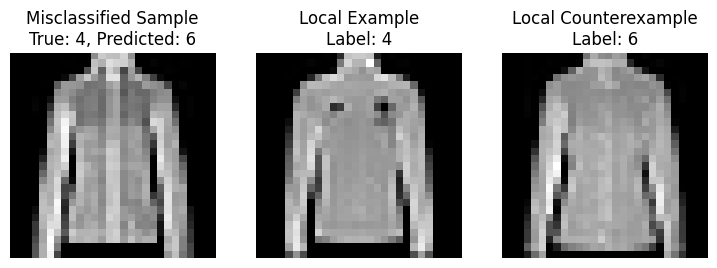

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


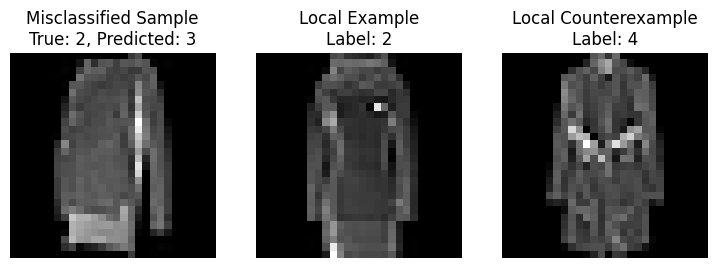

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


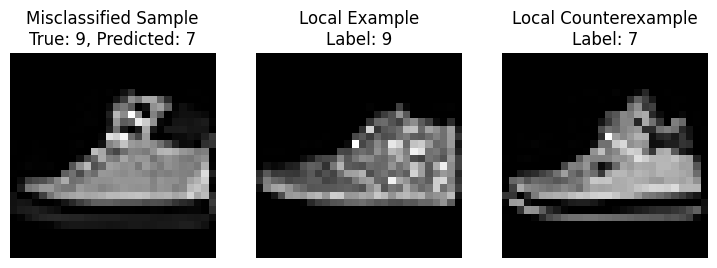

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


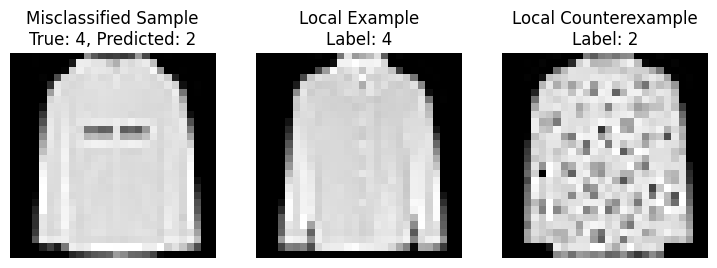

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


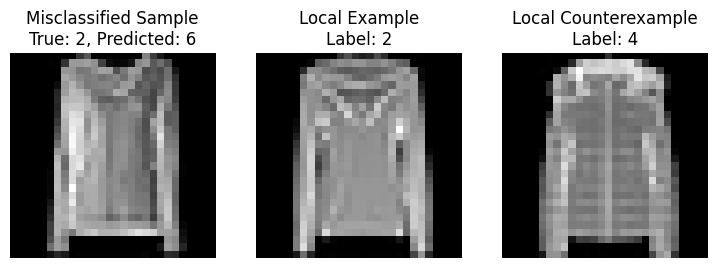

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


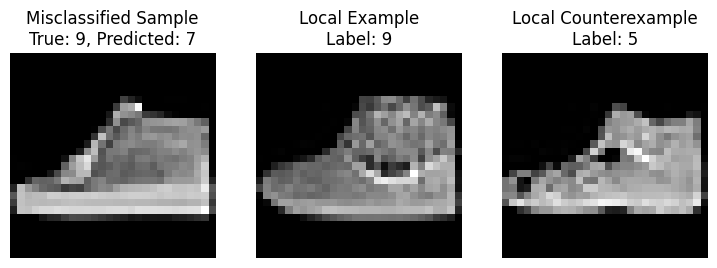

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


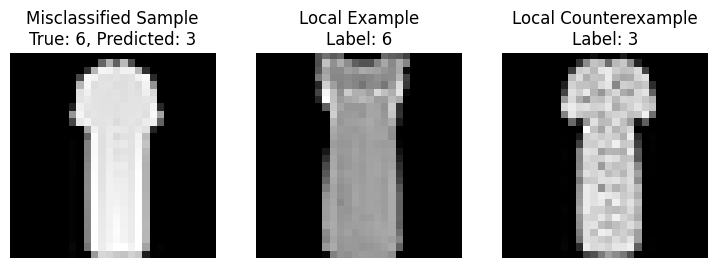

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


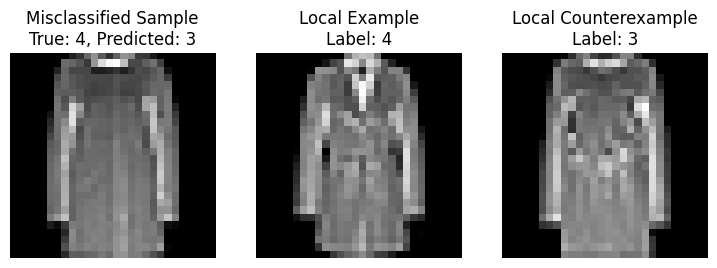

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


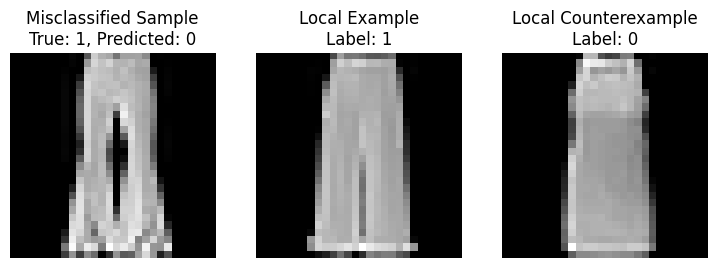

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


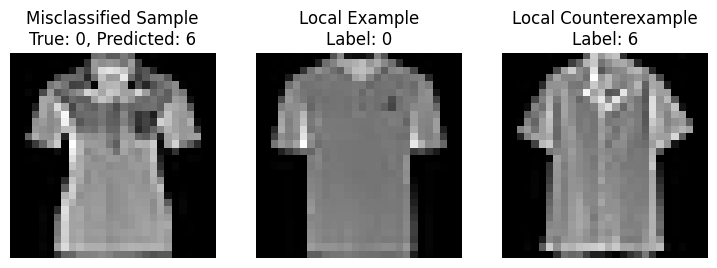

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


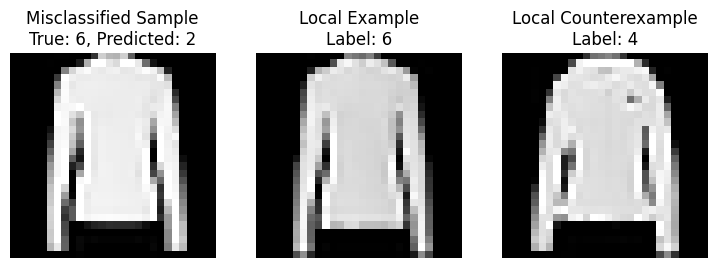

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


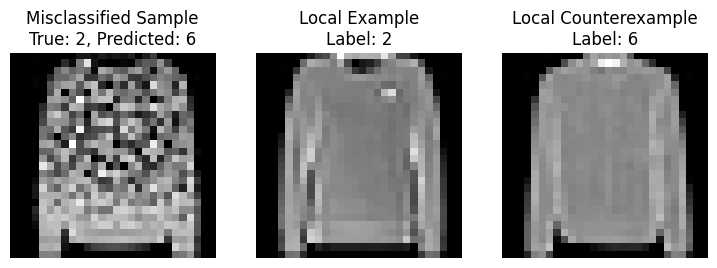

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


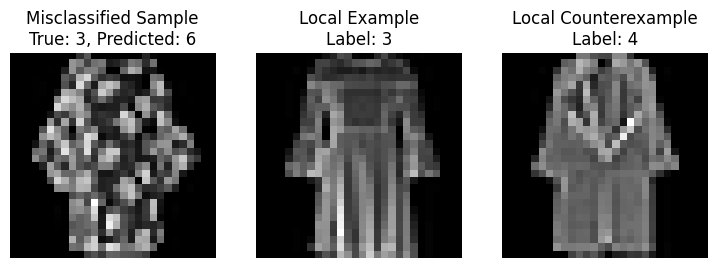

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


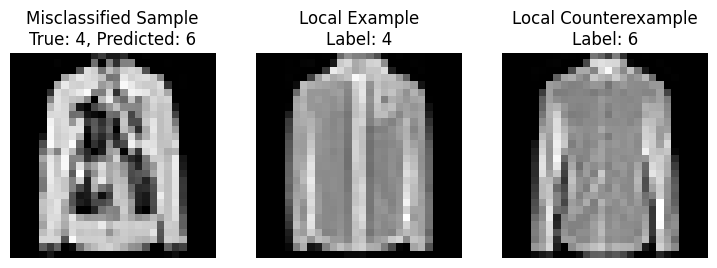

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


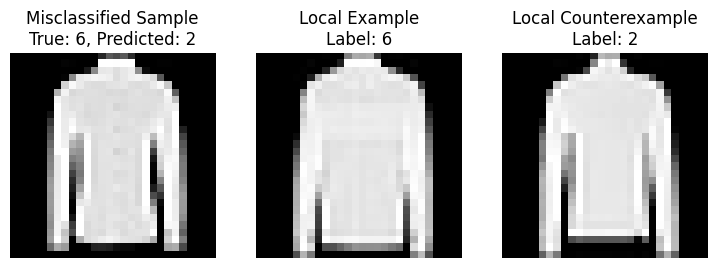

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


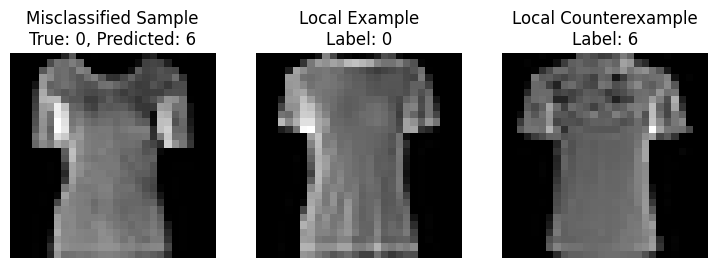

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


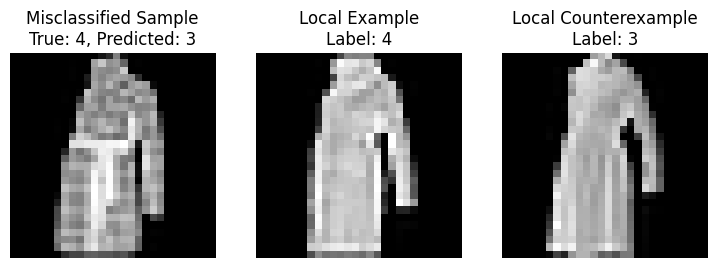

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


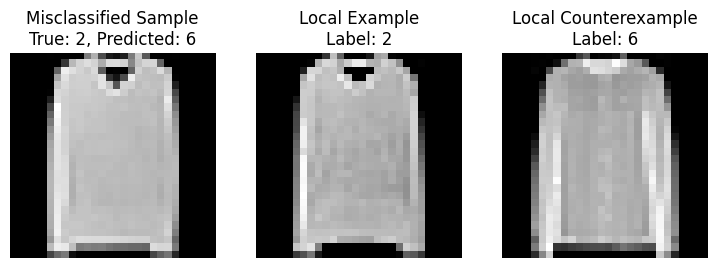

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


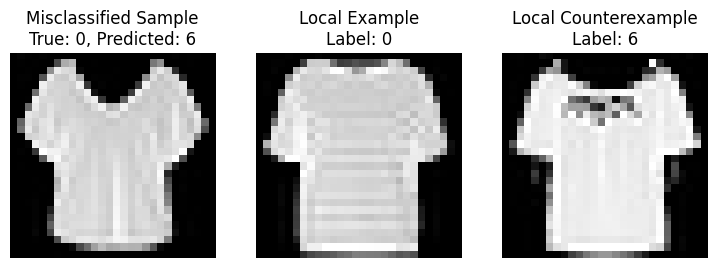

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


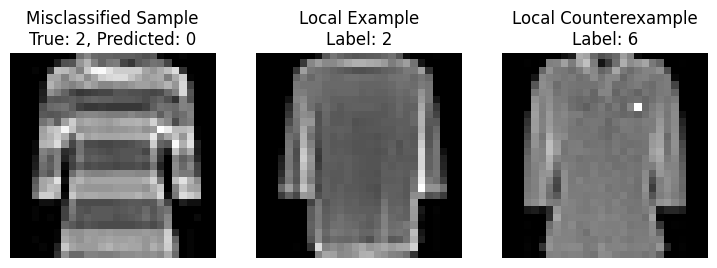

In [8]:
# Load the final version of your classifier
classifier = tf.keras.models.load_model('model/final_classifier_regularized.h5')

# Evaluate the test dataset
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=0)

# Get predictions
y_pred_probs = classifier.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Find misclassified samples
misclassified_indices = np.where(y_pred != y_test)[0]

# Extract 25 misclassified samples
misclassified_samples = misclassified_indices[:25]

# Initialize list to store results
results = []

for idx in misclassified_samples:
    sample = x_test[idx]
    sample_label = y_test[idx]
    predicted_label = y_pred[idx]

    # Encode the sample
    encoded_sample = encoder.predict(np.expand_dims(sample, axis=0))
    encoded_sample_flat = encoded_sample.reshape(1, -1)

    # Find the local example (nearest neighbor with same label)
    same_label_indices = np.where(y_train == sample_label)[0]
    encoded_same_label = encoded_train_flat[same_label_indices]
    knn_same = NearestNeighbors(n_neighbors=1, metric='euclidean')
    knn_same.fit(encoded_same_label)
    dist_same, idx_same = knn_same.kneighbors(encoded_sample_flat)
    local_example_idx = same_label_indices[idx_same[0][0]]
    local_example = x_train[local_example_idx]

    # Find the local counterexample (nearest neighbor with different label)
    diff_label_indices = np.where(y_train != sample_label)[0]
    encoded_diff_label = encoded_train_flat[diff_label_indices]
    knn_diff = NearestNeighbors(n_neighbors=1, metric='euclidean')
    knn_diff.fit(encoded_diff_label)
    dist_diff, idx_diff = knn_diff.kneighbors(encoded_sample_flat)
    local_counterexample_idx = diff_label_indices[idx_diff[0][0]]
    local_counterexample = x_train[local_counterexample_idx]

    # Plot the misclassified sample, local example, and local counterexample
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(sample.squeeze(), cmap='gray')
    plt.title(f'Misclassified Sample\nTrue: {sample_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(local_example.squeeze(), cmap='gray')
    plt.title(f'Local Example\nLabel: {sample_label}')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(local_counterexample.squeeze(), cmap='gray')
    plt.title(f'Local Counterexample\nLabel: {y_train[local_counterexample_idx]}')
    plt.axis('off')
    plt.show()

    # Placeholder for actual analysis
    causes = [] # TODO: Manual
    causes.append('TODO')
    results.append({
        'index': idx,
        'true_label': sample_label,
        'predicted_label': predicted_label,
        'likely_causes': ';'.join(causes)
    })

# Write results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('csv/misclassification_causes.csv', index=False)

(Run after labeling misclassification_causes.csv)

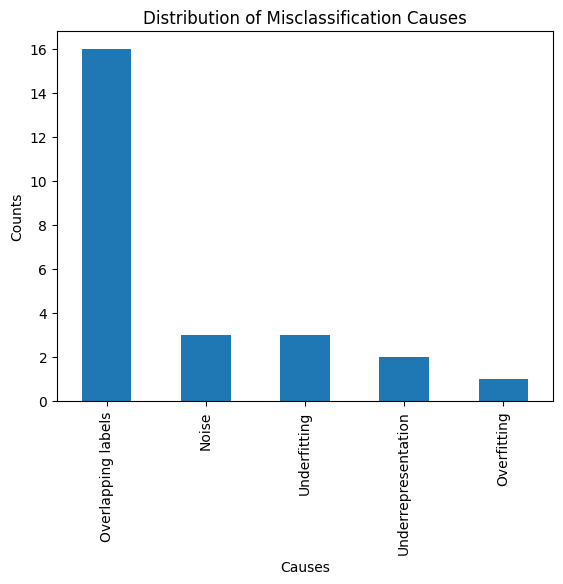

In [13]:
# Load the CSV into a pandas DataFrame and display the distribution
df = pd.read_csv('csv/misclassification_causes.csv')
cause_counts = df['likely_causes'].str.split(';').explode().value_counts()

# Plot the distribution in a histogram
cause_counts.plot(kind='bar')
plt.xlabel('Causes')
plt.ylabel('Counts')
plt.title('Distribution of Misclassification Causes')
plt.show()